# CuDNNLSTM - Time Serise Dataset

* 서울시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
* https://data.kma.go.kr/cmmn/main.do
* 기후통계분석 -> 기온분석 -> 기간(20110101~20191231) -> 검색 -> CSV 다운로드
* Seoul_Temp.csv

## Import Packages and GPU Check

* Packages

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM

* GPU 설정 확인

In [0]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Sun Mar 22 04:51:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |    565MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                          

# I. Colab File Upload

> ## 1) 'Seoul_temp.csv' 파일을 Colab에 업로드 후 진행

In [0]:
temp = pd.read_csv('Seoul_Temp.csv')

temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# II. Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

* 일일 평균온도 변화에 일정한 패턴 확인

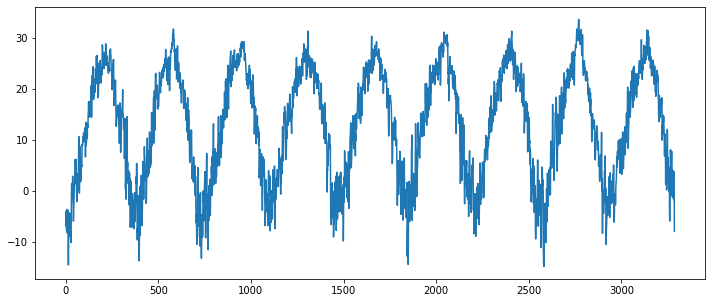

In [0]:
temp_data = temp[['avg']]

plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

* tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [0]:
scaler = MinMaxScaler(feature_range = (-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

* Train_Dataset : 2011년 01월 01일 ~ 2017년 12월 31일
* Test_Dataset : 2018년 01월 01일 ~ 2019년 12월 31일

In [0]:
train = temp_data[0:2557]
test  = temp_data[2557:]

# III. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

* X : 학습 평균온도 데이터
* y : 정답 평균온도 데이터
* 일정 기간의 X로 y를 예측하도록 학습

In [0]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])
        data_y.append(time_data[i + look_back, 0])

    return np.array(data_X), np.array(data_y)

> ## 2) loop_back 기간 설정 후 학습데이터 생성

* 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [0]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test, look_back)

> ## 3) Tensor Reshape

In [0]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# IV. CuDNNLSTM Keras Modeling

> ## 1) Model Define

In [0]:
model = Sequential()
model.add(CuDNNLSTM(64, 
                    input_shape=(None, 1)))
model.add(Dense(1, activation = 'tanh'))

* Model Summary

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                17152     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [0]:
model.compile(loss = 'mean_squared_error', 
              optimizer='adam')

> ## 3) Model Fit
* 약 5분

In [0]:
hist = model.fit(train_X, train_y,
                 epochs = 200, 
                 batch_size = 16,  
                 validation_data = (test_X, test_y))




Train on 2377 samples, validate on 550 samples
Epoch 1/200





2377/2377 [==============================] - 14s 6ms/step - loss: 0.0281 - val_loss: 0.0158
Epoch 2/200
2377/2377 [==============================] - 1s 515us/step - loss: 0.0171 - val_loss: 0.0139
Epoch 3/200
2377/2377 [==============================] - 1s 515us/step - loss: 0.0156 - val_loss: 0.0129
Epoch 4/200
2377/2377 [==============================] - 1s 513us/step - loss: 0.0145 - val_loss: 0.0123
Epoch 5/200
2377/2377 [==============================] - 1s 522us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 6/200
2377/2377 [==============================] - 1s 528us/step - loss: 0.0121 - val_loss: 0.0114
Epoch 7/200
2377/2377 [==============================] - 1s 517us/step - loss: 0.0106 - val_loss: 0.0088
Epoch 8/200
2377/2377 [==============================] - 1s 522us/step - loss: 0.0093 - val_loss: 0.0083
Epoch 9/200
2377/2377 [==============================] - 1s 533us/step - loss: 0.0093 - val_loss: 0.0088
E

> ## 4) 학습결과 시각화

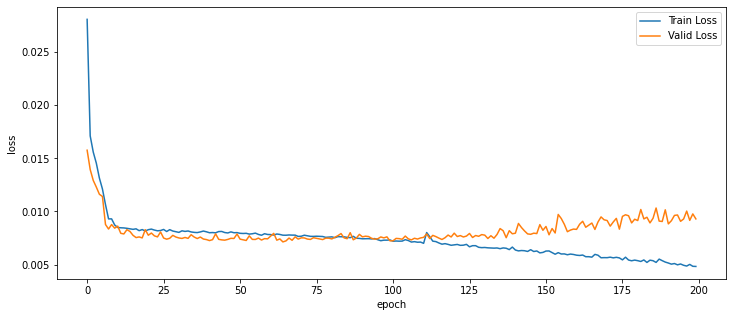

In [0]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.show()

> ## 5) Model Evaluate

In [0]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score: ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score: ', testScore)

Train Score:  0.004446109910611162
Test Score:  0.009300974770025774


# V. Model Predict

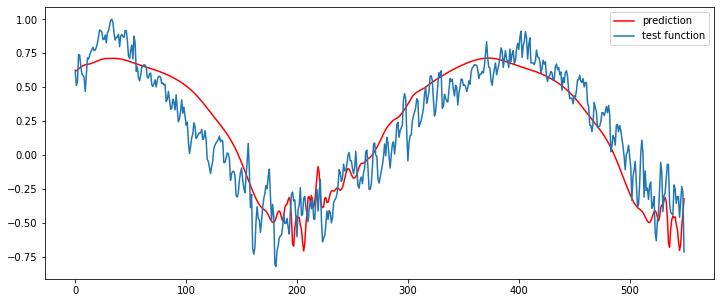

In [0]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])
    
plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = "prediction")
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = "test function")
plt.legend()
plt.show()

# 
# 
# 
# The End
# 
# 
# 